Note: The file contains little documentation. Refer to main_project.ipynb for full details.

In [ ]:
!pip install quantile_forest
from IPython.display import display
import altair as alt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from datetime import time
from sklearn.model_selection import KFold
from sklearn.utils.validation import check_random_state
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from quantile_forest import RandomForestQuantileRegressor
np.random.seed(42)
rng = check_random_state(0)

In [ ]:
def plot_multioutputs(df, legend):
    click = alt.selection_multi(fields=["target"])

    color = alt.condition(
        click,
        alt.Color(
            "target:N",
            legend=alt.Legend(symbolOpacity=1),
            scale=alt.Scale(range=list(legend.values())),
            sort=list(legend.keys()),
            title="Target",
        ),
        alt.value("lightgray"),
    )

    tooltip = [
        alt.Tooltip("target:N", title="Target"),
        alt.Tooltip("x:Q", format=",.3f", title="X"),
        alt.Tooltip("y:Q", format=",.3f", title="Y"),
        alt.Tooltip("y_true:Q", format=",.3f", title="Y"),
        alt.Tooltip("y_pred:Q", format=",.3f", title="Predicted Y"),
        alt.Tooltip("y_pred_low:Q", format=",.3f", title="Predicted Lower Y"),
        alt.Tooltip("y_pred_upp:Q", format=",.3f", title="Predicted Upper Y"),
    ]

    points = (
        alt.Chart(df)
        .mark_circle(color="black", opacity=0.25, size=25)
        .encode(
            x=alt.X("x:Q", scale=alt.Scale(nice=False)),
            y=alt.Y("y:Q"),
            color=color,
            tooltip=tooltip,
        )
    )

    line = (
        alt.Chart(df)
        .mark_line(color="black", size=3)
        .encode(
            x=alt.X("x:Q", scale=alt.Scale(nice=False), title="x"),
            y=alt.Y("y_pred:Q", title="y"),
            color=color,
            tooltip=tooltip,
        )
    )

    area = (
        alt.Chart(df)
        .mark_area(opacity=0.25)
        .encode(
            x=alt.X("x:Q", scale=alt.Scale(nice=False), title="x"),
            y=alt.Y("y_pred_low:Q", title="y"),
            y2=alt.Y2("y_pred_upp:Q", title=None),
            color=color,
            tooltip=tooltip,
        )
    )

    chart = (
        (points + area + line)
        .add_selection(click)
        .configure_range(category=alt.RangeScheme(list(legend.values())))
        .properties(height=400, width=650, title="Multi-target Prediction Intervals")
    )

    display(chart)
    return chart

**Multi target prediction using motor temperatures data**

In [ ]:
legend = {
    "pm": "#f2a619",
    "stator_yoke": "#006aff",
    "stator_tooth": '#ff0000',
    "stator_winding": '#00ff00'
}

df = pd.read_csv("motor_temperatures.csv",nrows=1000)
X = df.drop(['pm', 'stator_yoke', 'stator_tooth', 'stator_winding'], axis=1).values
y = df[['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

qrf = RandomForestQuantileRegressor(max_samples_leaf=None, max_depth=4, random_state=0)
qrf.fit(X_train, y_train)
y_pred = qrf.predict(X, quantiles=[0.025, 0.5, 0.975])
funcs=[0,1,2,3]
np.tile(X, len(funcs))
ar=np.linspace(1,1000,1000)
# Update the DataFrame with the new y_true values (which are already loaded)
df = pd.DataFrame(
    {
        "x": np.tile(ar, len(funcs)),
        "y": y.reshape(-1, order="F"),
        "y_true": y.reshape(-1, order="F"),  # Use the correct column name or adjust accordingly
        "y_pred": np.concatenate([y_pred[:, i, 1] for i in range(len(funcs))]),
        "y_pred_low": np.concatenate([y_pred[:, i, 0] for i in range(len(funcs))]),
        "y_pred_upp": np.concatenate([y_pred[:, i, 2] for i in range(len(funcs))]),
        "target": np.concatenate([[f"{i}"] * len(X) for i in range(len(funcs))]),
    }
)




chart = plot_multioutputs(df, legend)


alt.LayerChart(...)

![](https://drive.google.com/uc?export=view&id=1RqFPoz7riZIMbi8VB1qhMmfYuXkYpDa4)

Whereas in the above graph 0 represents pm, 1 represents stator_yoke, 2 represents stator_tooth and 3 represents stator_winding

**Multi target prediction using self generated data**

In [ ]:
n_samples = 2500
bounds = [0, 100]

# Define functions that generate targets; each function maps to one target.
funcs = [
    {
        "signal": lambda x: np.log1p(x + 1),
        "noise": lambda x: np.log1p(x) * np.random.uniform(size=len(x)),
    },
    {
        "signal": lambda x: np.log1p(np.sqrt(x)),
        "noise": lambda x: np.log1p(x / 2) * np.random.uniform(size=len(x)),
    },
]

legend = {
    "0": "#f2a619",
    "1": "#006aff",
}


def make_func_Xy(funcs, bounds, n_samples):
    x = np.linspace(*bounds, n_samples)
    y = np.empty((len(x), len(funcs)))
    for i, func in enumerate(funcs):
        y[:, i] = func["signal"](x) + func["noise"](x)
    return np.atleast_2d(x).T, y


# Create the dataset with multiple target variables.
X, y = make_func_Xy(funcs, bounds, n_samples)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

qrf = RandomForestQuantileRegressor(max_samples_leaf=None, max_depth=4, random_state=0)
qrf.fit(X_train, y_train)  # fit on all of the targets simultaneously

# Get multiple-output predictions at 95% prediction intervals and median.
y_pred = qrf.predict(X, quantiles=[0.025, 0.5, 0.975])

df = pd.DataFrame(
    {
        "x": np.tile(X.squeeze(), len(funcs)),
        "y": y.reshape(-1, order="F"),
        "y_true": np.concatenate([f["signal"](X.squeeze()) for f in funcs]),
        "y_pred": np.concatenate([y_pred[:, i, 1] for i in range(len(funcs))]),
        "y_pred_low": np.concatenate([y_pred[:, i, 0] for i in range(len(funcs))]),
        "y_pred_upp": np.concatenate([y_pred[:, i, 2] for i in range(len(funcs))]),
        "target": np.concatenate([[f"{i}"] * len(X) for i in range(len(funcs))]),
    }
)


def plot_multioutputs(df, legend):
    click = alt.selection_multi(fields=["target"])

    color = alt.condition(
        click,
        alt.Color(
            "target:N",
            legend=alt.Legend(symbolOpacity=1),
            scale=alt.Scale(range=list(legend.values())),
            sort=list(legend.keys()),
            title="Target",
        ),
        alt.value("lightgray"),
    )

    tooltip = [
        alt.Tooltip("target:N", title="Target"),
        alt.Tooltip("x:Q", format=",.3f", title="X"),
        alt.Tooltip("y:Q", format=",.3f", title="Y"),
        alt.Tooltip("y_true:Q", format=",.3f", title="Y"),
        alt.Tooltip("y_pred:Q", format=",.3f", title="Predicted Y"),
        alt.Tooltip("y_pred_low:Q", format=",.3f", title="Predicted Lower Y"),
        alt.Tooltip("y_pred_upp:Q", format=",.3f", title="Predicted Upper Y"),
    ]

    points = (
        alt.Chart(df)
        .mark_circle(color="black", opacity=0.25, size=25)
        .encode(
            x=alt.X("x:Q", scale=alt.Scale(nice=False)),
            y=alt.Y("y:Q"),
            color=color,
            tooltip=tooltip,
        )
    )

    line = (
        alt.Chart(df)
        .mark_line(color="black", size=3)
        .encode(
            x=alt.X("x:Q", scale=alt.Scale(nice=False), title="x"),
            y=alt.Y("y_pred:Q", title="y"),
            color=color,
            tooltip=tooltip,
        )
    )

    area = (
        alt.Chart(df)
        .mark_area(opacity=0.25)
        .encode(
            x=alt.X("x:Q", scale=alt.Scale(nice=False), title="x"),
            y=alt.Y("y_pred_low:Q", title="y"),
            y2=alt.Y2("y_pred_upp:Q", title=None),
            color=color,
            tooltip=tooltip,
        )
    )

    chart = (
        (points + area + line)
        .add_selection(click)
        .configure_range(category=alt.RangeScheme(list(legend.values())))
        .properties(height=400, width=650, title="Multi-target Prediction Intervals")
    )
    display(chart)
    return chart


chart = plot_multioutputs(df, legend)

alt.LayerChart(...)

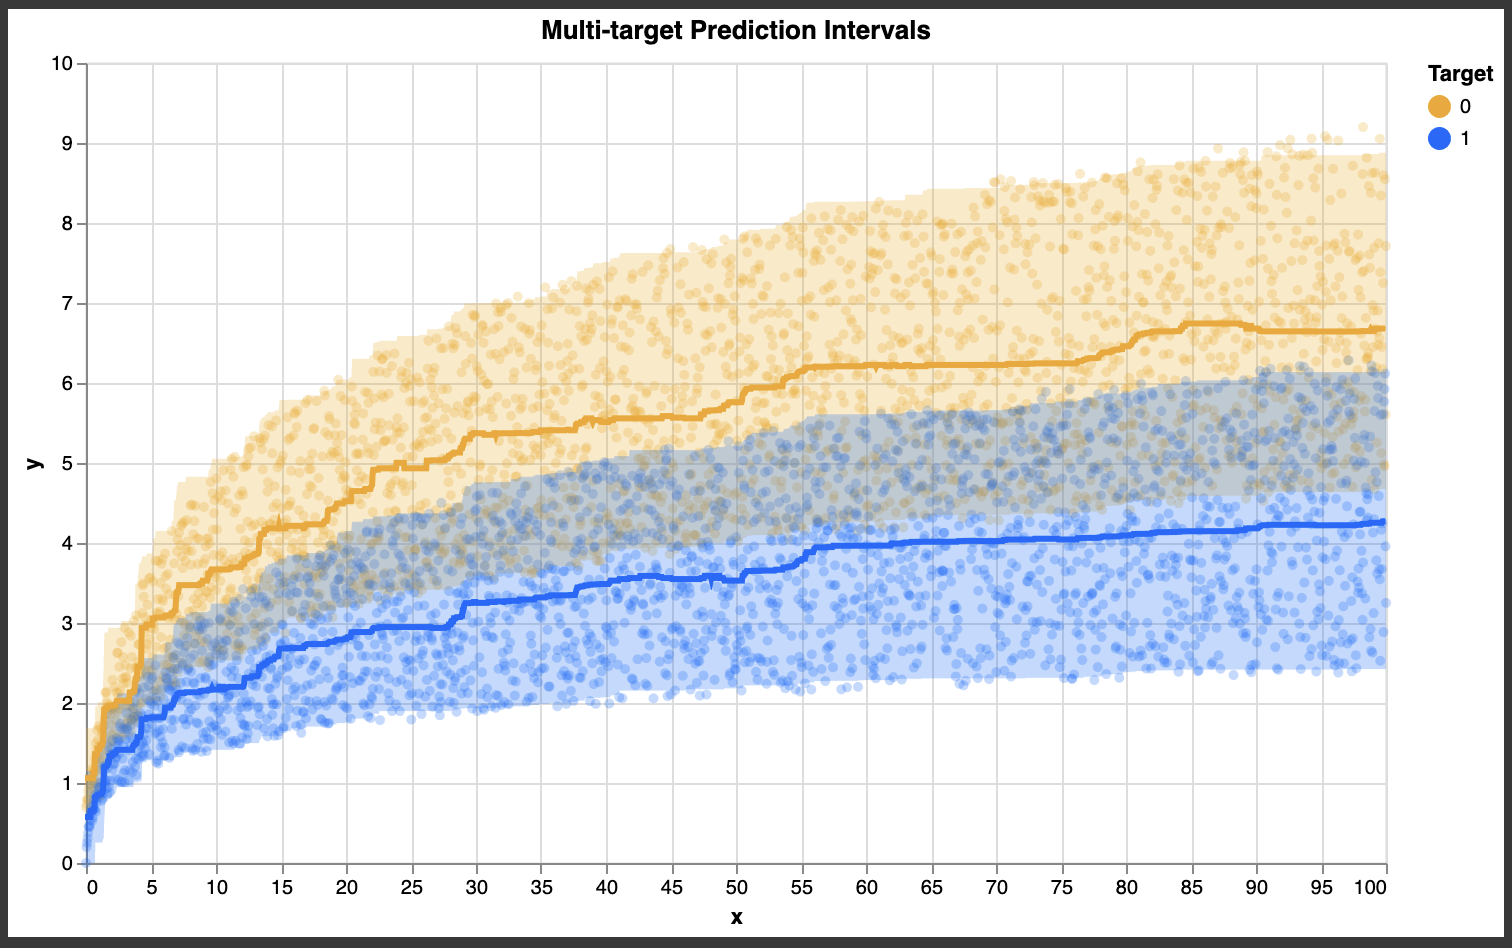

Yellow line is log(x + 1)
Blue line is log(x ^ 0.5)